In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Input, concatenate
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/CA-HW2/emotions'

In [4]:
print("folder:")
print(os.listdir(path))

folder:
['fer2013.csv']


In [5]:
file_path = '/content/drive/My Drive/CA-HW2/emotions/fer2013.csv'

In [6]:
def getData(file):
    Y = []
    X = []
    first = True
    for line in open(file):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X), np.array(Y)
    return X, Y

In [7]:
X, Y = getData(file_path)
num_class = len(set(Y))
print(num_class)

7


In [8]:
N, D = X.shape

X = X.reshape(N, 48, 48, 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
x_train.shape

(28709, 48, 48, 1)

In [11]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 48, 48, 1))
x_test = np.reshape(x_test, (len(x_test), 48, 48, 1))

noise_factor = 0.15

from skimage.util import random_noise

x_train_noisy = random_noise(x_train, mode="s&p",clip=True, amount=noise_factor)
x_test_noisy = random_noise(x_test, mode="s&p",clip=True, amount=noise_factor)

In [12]:
x_test_final_noisy = x_test_noisy[-100:]
x_test_noisy = x_test_noisy[:-100]

x_test_final_original = x_test[-100:]
x_test = x_test[:-100]

visualize some data:

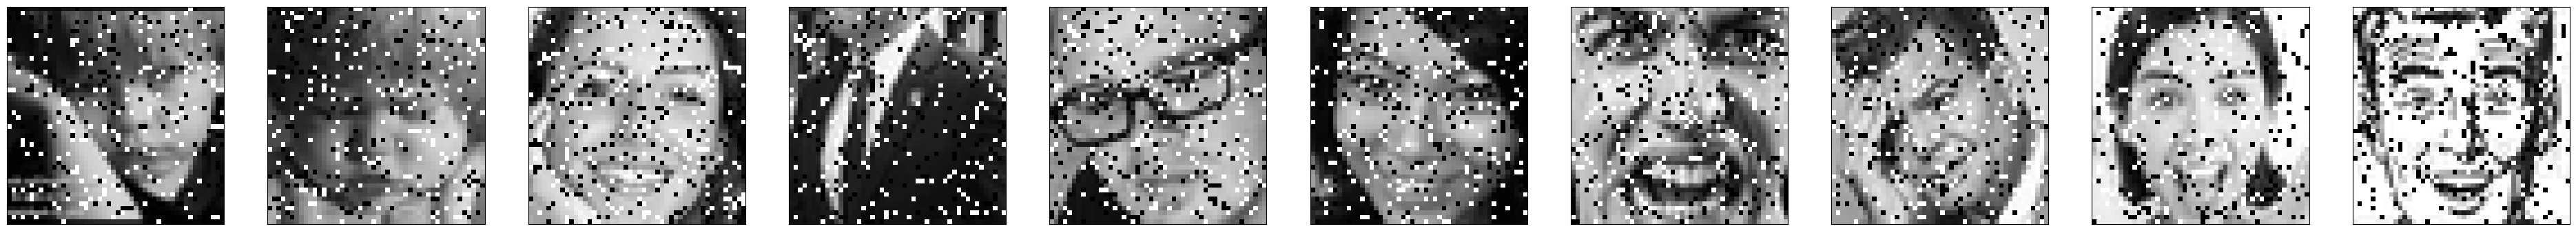

In [13]:
plt.figure(figsize=(48, 48))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(x_train_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    #Middle
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(pool4)
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(convm)

    #upconv part
    deconv4 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)

    output_layer = Conv2D(1, (1,1), padding='same', activation='sigmoid')(uconv1)
    return output_layer

In [15]:
img_size_target = 48
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer,64)

In [16]:
model_unet = Model(input_layer, output_layer)
model_unet.compile(optimizer='adam', loss='MSE')

Train:

In [17]:
model_unet.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 258s 475ms/step - loss: 0.0149 - val_loss: 0.0020
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 168s 374ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 203s 377ms/step - loss: 0.0013 - val_loss: 7.6339e-04
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 194s 360ms/step - loss: 9.9921e-04 - val_loss: 7.6909e-04
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 168s 375ms/step - loss: 8.4856e-04 - val_loss: 5.7514e-04
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 195s 360ms/step - loss: 7.5416e-04 - val_loss: 4.7391e-04
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 168s 375ms/step - loss: 6.7011e-04 - val_loss: 4.3751e-04
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 203s 377ms/step - loss: 6.1491e-04 - val_loss: 3.7160e-04
Epoch 9/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 377ms/step - loss: 5.7688e-04 - val_loss: 3.4102e-04
Epoch 10/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 161s 359ms/step - loss: 5.3959e-04 - val_loss: 3.4800e-04


In [18]:
predict = model_unet.predict(x_test_final_noisy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


visualize predict:

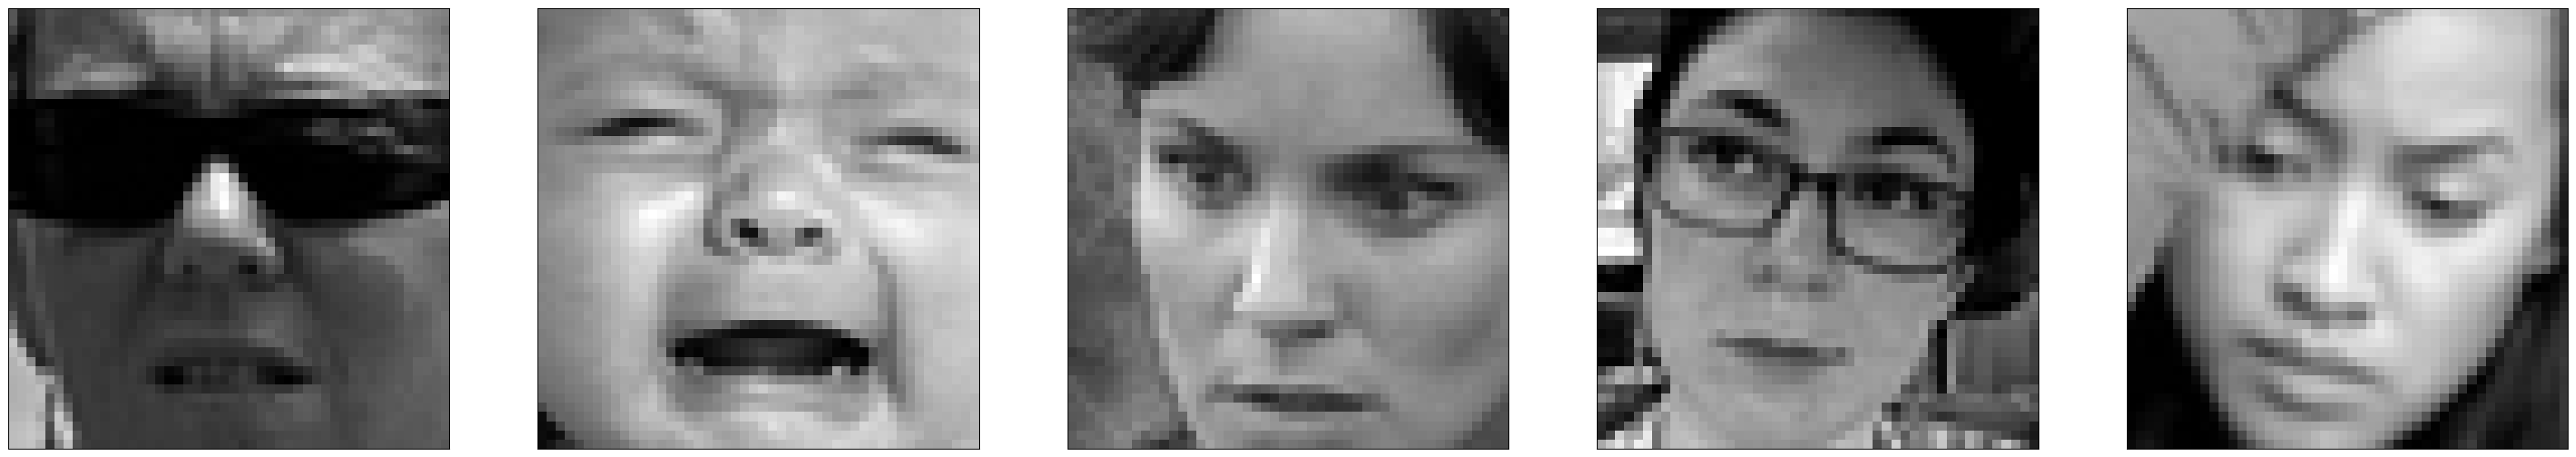

In [19]:
plt.figure(figsize=(40, 48))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(x_test_final_original[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plot noisy images of what shown above:

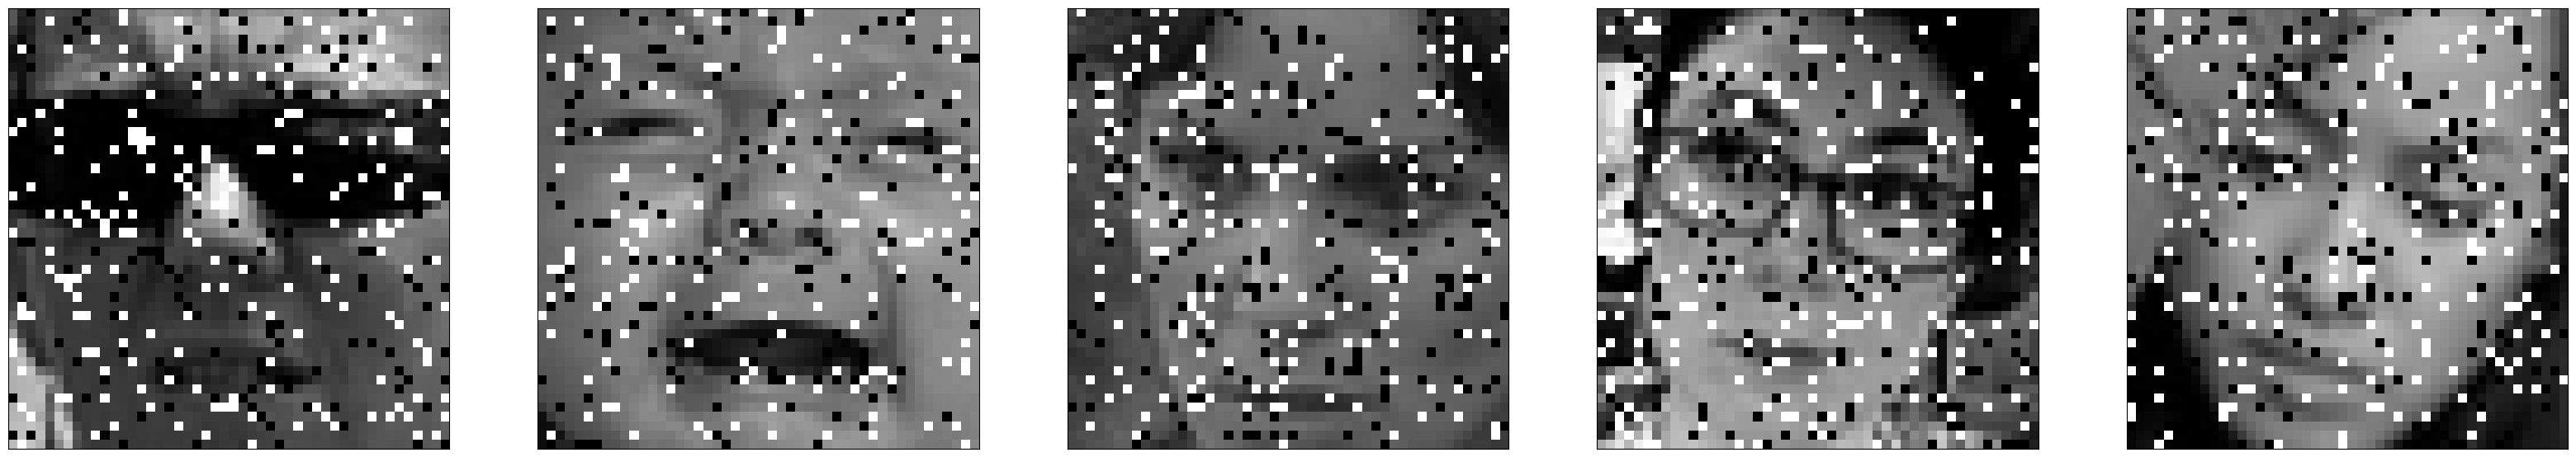

In [20]:
plt.figure(figsize=(40, 48))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(x_test_final_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [31]:
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import mean_squared_error as compare_mse
from skimage import data, img_as_float

In [32]:
compare_mse(x_test_final_original[3], predict[3])

0.0008200069910935707

In [33]:
compare_mse(x_test_final_original[4], predict[4])

9.887719332817004e-05

totally:

In [34]:
compare_mse(x_test_final_original, predict)

0.00034997481951814884

TOTAL SSIM:

In [43]:
from skimage.metrics import structural_similarity as compare_ssim

ssim_score = compare_ssim(
    x_test_final_original.squeeze(),
    predict.squeeze(),
    multichannel=False,
    win_size=3,
    data_range=1
)
print("SSIM Score:", ssim_score)


SSIM Score: 0.993982079377013


total PSNR:

In [44]:
compare_psnr(x_test_final_original, predict)

34.55963201757497